In [115]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
import kagglehub

Arrythmia Dataset
- Number of samples: 109446
- Number of categories: 5
- Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
- Sampling Frequency: 125Hz
- Data Source: Physionet's MIT-BIH Arrythmia Dataset

In [116]:
# Download latest version
path = kagglehub.dataset_download("shayanfazeli/heartbeat")

In [117]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [118]:
# Set seeds
seed_value = 0
torch.manual_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Data exploration

In [119]:
train_df = pd.read_csv(path + '/mitbih_train.csv')
test_df = pd.read_csv(path + '/mitbih_test.csv')

In [120]:
print(f"Shape of train data: {train_df.shape}")
print(f"Shape of test data: {test_df.shape}")

Shape of train data: (87553, 188)
Shape of test data: (21891, 188)


In [121]:
# If your dataframes don't have column names, assign them
# This creates columns named '0', '1', '2', ...
train_df.columns = [str(i) for i in range(train_df.shape[1])]
test_df.columns = [str(i) for i in range(test_df.shape[1])]

In [122]:
print(f"NaN values in train data: {train_df.isna().sum().sum()}")
print(f"NaN values in test data: {test_df.isna().sum().sum()}")

NaN values in train data: 0
NaN values in test data: 0


In [123]:
# Last column stores the labels
print(train_df.iloc[:, -1].unique())
print(test_df.iloc[:, -1].unique())

[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]


In [124]:
train_df.iloc[:, -1].value_counts()

187
0.0    72470
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

In [125]:
test_df.iloc[:, -1].value_counts()

187
0.0    18117
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64

From the counts of the classes, we can observe that the dataset is imbalanced, as class = 0 makes up a large proportion of the training (82.77%) and test data (82.76%). However, we will go ahead with training and evaluating for now and observe the results.

## Generating Training Data

In [126]:
df_train, df_val = train_test_split(train_df, test_size=0.2, random_state=0)
print(df_train.shape)
print(df_val.shape)

(70042, 188)
(17511, 188)


In [127]:
x_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]

x_val = df_val.iloc[:, :-1]
y_val = df_val.iloc[:, -1]

x_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]

x_train = torch.tensor(x_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

x_val = torch.tensor(x_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.long)

x_test = torch.tensor(x_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

## Hybrid CNN-RNN Model

In [128]:
class CNN_RNN_Hybrid(nn.Module):
  def __init__(self, input_dim, cnn_output_dim, hidden_dim, num_classes, num_layers=1, bidirectional=False):
    super(CNN_RNN_Hybrid, self).__init__()

    self.cnn = nn.Sequential(
      nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool1d(kernel_size=2),
      nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool1d(kernel_size=2),
      nn.Conv1d(in_channels=32, out_channels=cnn_output_dim, kernel_size=3, padding=1),
      nn.ReLU()
    )

    self.rnn = nn.LSTM(input_size=cnn_output_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)

    if bidirectional:
        hidden_dim *= 2
        
    self.fc = nn.Linear(hidden_dim, num_classes)

  def forward(self, x):
    x = x.unsqueeze(1)
    cnn_output = self.cnn(x)
    cnn_output = cnn_output.permute(0, 2, 1)

    rnn_output, _ = self.rnn(cnn_output)

    final_output = rnn_output[:, -1, :]

    output = self.fc(final_output)

    return output

In [129]:
def train_loop(train_dataloader, model, loss_fn, optimizer):
  size = len(train_dataloader.dataset)
  num_batches = len(train_dataloader)
  train_loss, train_correct = 0, 0

  for batch, (X, y) in enumerate(train_dataloader):
    # Move inputs and labels to the same device as the model (GPU or CPU)
    X = X.to(device)
    y = y.to(device)

    # Compute prediction and loss
    outputs = model(X)
    loss = loss_fn(outputs, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    train_correct += (predicted == y).sum().item()

  train_loss /= num_batches
  train_correct /= size

  return train_loss, train_correct

def test_loop(test_dataloader, model, loss_fn):
  size = len(test_dataloader.dataset)
  num_batches = len(test_dataloader)
  test_loss, test_correct = 0, 0

  with torch.no_grad():
    for X, y in test_dataloader:
      # Move inputs and labels to the same device as the model (GPU or CPU)
      X = X.to(device)
      y = y.to(device)

      outputs = model(X)
      test_loss += loss_fn(outputs, y).item()

      _, predicted = torch.max(outputs.data, 1)
      test_correct += (predicted == y).sum().item()

  test_loss /= num_batches
  test_correct /= size

  return test_loss, test_correct

In [130]:
class EarlyStopper:
  def __init__(self, patience=3, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_validation_loss = np.inf

  def early_stop(self, validation_loss):
    if validation_loss < self.min_validation_loss:
      self.min_validation_loss = validation_loss
      self.counter = 0
    elif validation_loss > (self.min_validation_loss + self.min_delta):
      self.counter += 1
      if self.counter >= self.patience:
        return True
    return False

## Training & Evaluation of Model

In [131]:
input_size = 187
cnn_output_size = 64
hidden_size = 128
num_classes = 5

patience = 3
no_epochs = 50
batch_size = 64
lr = 0.001

In [132]:
def train(model, x_train, y_train, x_test, y_test, batch_size):
  train_losses, train_accuracies = [], []
  test_losses, test_accuracies = [], []

  early_stopper = EarlyStopper(patience=patience, min_delta=0)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)

  # Convert data to TensorDataset for DataLoader
  train_dataset = TensorDataset(x_train, y_train)
  test_dataset = TensorDataset(x_test, y_test)

  # Loaders for batching
  train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  for epoch in range(no_epochs):
    train_loss, train_correct = train_loop(train_loader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_loader, model, loss_fn)

    train_losses.append(train_loss)
    train_accuracies.append(train_correct)
    test_losses.append(test_loss)
    test_accuracies.append(test_correct)

    print(f"Epoch {epoch+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Val_accuracy: {(100*test_correct):>0.2f}%, Val_loss: {test_loss:>8f}")

    if early_stopper.early_stop(test_loss):
      print('Done')
      break

  return train_accuracies, train_losses, test_accuracies, test_losses

In [133]:
model = CNN_RNN_Hybrid(input_size, cnn_output_size, hidden_size, num_classes, bidirectional=False)
model.to(device)

CNN_RNN_Hybrid(
  (cnn): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ReLU()
  )
  (rnn): LSTM(64, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)

In [134]:
train_accuracies, train_losses, val_accuracies, val_losses = train(model, x_train, y_train, x_val, y_val, batch_size)

Epoch 1: Train_accuracy: 83.97%, Train_loss: 0.591055, Val_accuracy: 88.37%, Val_loss: 0.410624
Epoch 2: Train_accuracy: 92.09%, Train_loss: 0.318074, Val_accuracy: 93.10%, Val_loss: 0.270165
Epoch 3: Train_accuracy: 94.12%, Train_loss: 0.214070, Val_accuracy: 94.95%, Val_loss: 0.181319
Epoch 4: Train_accuracy: 95.54%, Train_loss: 0.161009, Val_accuracy: 95.83%, Val_loss: 0.148576
Epoch 5: Train_accuracy: 96.19%, Train_loss: 0.139940, Val_accuracy: 96.47%, Val_loss: 0.136533
Epoch 6: Train_accuracy: 96.74%, Train_loss: 0.123064, Val_accuracy: 96.11%, Val_loss: 0.135718
Epoch 7: Train_accuracy: 96.94%, Train_loss: 0.112542, Val_accuracy: 97.15%, Val_loss: 0.103689
Epoch 8: Train_accuracy: 97.24%, Train_loss: 0.101479, Val_accuracy: 96.86%, Val_loss: 0.112934
Epoch 9: Train_accuracy: 97.30%, Train_loss: 0.095541, Val_accuracy: 97.41%, Val_loss: 0.092167
Epoch 10: Train_accuracy: 97.58%, Train_loss: 0.088642, Val_accuracy: 97.45%, Val_loss: 0.090405
Epoch 11: Train_accuracy: 97.61%, Train

In [135]:
loss_fn = nn.CrossEntropyLoss()

# Convert data to TensorDataset for DataLoader
test_dataset = TensorDataset(x_test, y_test)

# Loaders for batching
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

test_loss, test_accuracy = test_loop(test_loader, model, loss_fn)
print(f"Test accuracy: {(100*test_accuracy):>0.2f}%, Test loss: {test_loss:>8f}")

Test accuracy: 97.68%, Test loss: 0.084945


We can observe that the accuracy on the test set is very good. However, as we found earlier, the dataset is imbalanced, which may mean that the accuracy could be misleading and not reflect actual performance of the predictions for all classes.

In [136]:
def get_predictions(model, test_loader, device):
  model.eval()  # Set model to evaluation mode
  predictions = []  # List to store predictions

  with torch.no_grad():  # Disable gradient calculation
    for inputs, _ in test_loader:  # We don't need labels for predictions
      # Move inputs to the correct device
      inputs = inputs.to(device)

      # Forward pass
      outputs = model(inputs)

      # Get predicted class labels
      _, predicted = torch.max(outputs, 1)

      # Append predictions to the list
      predictions.extend(predicted.cpu().numpy())  # Move to CPU and convert to numpy

  return predictions

# Get predictions for the test set
test_predictions = get_predictions(model, test_loader, device)

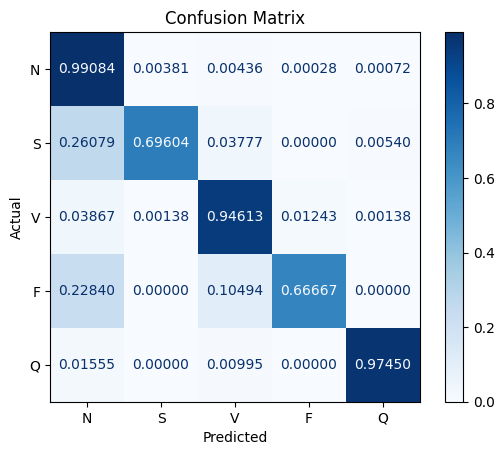

In [137]:
actual_labels = y_test.tolist()

class_labels = ["N", "S", "V", "F", "Q"]

cm = confusion_matrix(actual_labels, test_predictions, labels=[0,1,2,3,4])

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format=".5f")

plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [138]:
report = classification_report(actual_labels, test_predictions, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           N       0.99      0.99      0.99     18117
           S       0.84      0.70      0.76       556
           V       0.91      0.95      0.93      1448
           F       0.82      0.67      0.74       162
           Q       0.99      0.97      0.98      1608

    accuracy                           0.98     21891
   macro avg       0.91      0.85      0.88     21891
weighted avg       0.98      0.98      0.98     21891



Testing bidirectional = True for LSTM layer

In [139]:
model = CNN_RNN_Hybrid(input_size, cnn_output_size, hidden_size, num_classes, bidirectional=True)
model.to(device)

CNN_RNN_Hybrid(
  (cnn): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ReLU()
  )
  (rnn): LSTM(64, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)

In [140]:
train_accuracies, train_losses, val_accuracies, val_losses = train(model, x_train, y_train, x_val, y_val, batch_size)

Epoch 1: Train_accuracy: 84.47%, Train_loss: 0.582165, Val_accuracy: 89.74%, Val_loss: 0.368822
Epoch 2: Train_accuracy: 93.05%, Train_loss: 0.269188, Val_accuracy: 94.29%, Val_loss: 0.214923
Epoch 3: Train_accuracy: 94.29%, Train_loss: 0.210642, Val_accuracy: 95.17%, Val_loss: 0.166979
Epoch 4: Train_accuracy: 95.38%, Train_loss: 0.159868, Val_accuracy: 96.17%, Val_loss: 0.138057
Epoch 5: Train_accuracy: 96.29%, Train_loss: 0.132247, Val_accuracy: 96.69%, Val_loss: 0.120288
Epoch 6: Train_accuracy: 96.83%, Train_loss: 0.113324, Val_accuracy: 97.06%, Val_loss: 0.105072
Epoch 7: Train_accuracy: 97.00%, Train_loss: 0.104767, Val_accuracy: 97.17%, Val_loss: 0.100186
Epoch 8: Train_accuracy: 97.10%, Train_loss: 0.103640, Val_accuracy: 97.21%, Val_loss: 0.099421
Epoch 9: Train_accuracy: 97.43%, Train_loss: 0.091192, Val_accuracy: 97.49%, Val_loss: 0.088449
Epoch 10: Train_accuracy: 97.58%, Train_loss: 0.084813, Val_accuracy: 97.55%, Val_loss: 0.088593
Epoch 11: Train_accuracy: 97.66%, Train

In [141]:
loss_fn = nn.CrossEntropyLoss()

# Convert data to TensorDataset for DataLoader
test_dataset = TensorDataset(x_test, y_test)

# Loaders for batching
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

test_loss, test_accuracy = test_loop(test_loader, model, loss_fn)
print(f"Test accuracy: {(100*test_accuracy):>0.2f}%, Test loss: {test_loss:>8f}")

Test accuracy: 97.58%, Test loss: 0.085569


In [142]:
test_predictions = get_predictions(model, test_loader, device)
report = classification_report(actual_labels, test_predictions, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           N       0.99      0.99      0.99     18117
           S       0.86      0.67      0.76       556
           V       0.90      0.95      0.93      1448
           F       0.70      0.77      0.73       162
           Q       0.98      0.98      0.98      1608

    accuracy                           0.98     21891
   macro avg       0.89      0.87      0.88     21891
weighted avg       0.98      0.98      0.98     21891



From the relative accuracies for the different classes, we can observe that the model does not perform that well in predicting samples in class 1, 2 and 3 relative to class 0 and 4 as can be observed by the f1-score.

We can explore ways to augment the original datasets to tackle this.

## Data Transformation

We will try SMOTE to deal with the imbalanced dataset:

### SMOTE

In [162]:
from sklearn.preprocessing import MinMaxScaler

smote_over_sampler = SMOTE()
x_resampled, y_resampled = smote_over_sampler.fit_resample(df_train.iloc[:, :-1], df_train.iloc[:,-1])

scaler = MinMaxScaler()
X_resampled_scaled = scaler.fit_transform(x_resampled)
y_train = y_resampled.values

x_test_scaled = scaler.transform(x_test)

x_train_resampled, x_val_resampled, y_train_resampled, y_val_resampled = train_test_split(X_resampled_scaled, y_train, test_size=0.2, random_state=seed_value)

# x_train_resampled = df_train_resampled.iloc[:, :-1]
# y_train_resampled = df_train_resampled.iloc[:, -1]

# x_val_resampled = df_val_resampled.iloc[:, :-1]
# y_val_resampled = df_val_resampled.iloc[:, -1]

x_train_resampled = torch.tensor(x_train_resampled, dtype=torch.float32)
y_train_resampled = torch.tensor(y_train_resampled, dtype=torch.long)

x_val_resampled = torch.tensor(x_val_resampled, dtype=torch.float32)
y_val_resampled = torch.tensor(y_val_resampled, dtype=torch.long)

x_test = torch.tensor(x_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/tmp/ipykernel_30/1851780834.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long)


In [163]:
# Observe new count for classes
unique, counts = np.unique(y_train_resampled, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    0 46290]
 [    1 46362]
 [    2 46415]
 [    3 46328]
 [    4 46469]]


In [164]:
smote_model = CNN_RNN_Hybrid(input_size, cnn_output_size, hidden_size, num_classes, bidirectional=True)
smote_model.to(device)

CNN_RNN_Hybrid(
  (cnn): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ReLU()
  )
  (rnn): LSTM(64, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)

In [165]:
train_accuracies, train_losses, val_accuracies, val_losses = train(smote_model, x_train_resampled, y_train_resampled, x_val_resampled, y_val_resampled, batch_size)

Epoch 1: Train_accuracy: 76.68%, Train_loss: 0.614302, Val_accuracy: 89.18%, Val_loss: 0.302197
Epoch 2: Train_accuracy: 92.00%, Train_loss: 0.225886, Val_accuracy: 94.18%, Val_loss: 0.163120
Epoch 3: Train_accuracy: 94.97%, Train_loss: 0.144898, Val_accuracy: 95.83%, Val_loss: 0.119879
Epoch 4: Train_accuracy: 96.19%, Train_loss: 0.109284, Val_accuracy: 96.87%, Val_loss: 0.091891
Epoch 5: Train_accuracy: 97.02%, Train_loss: 0.087891, Val_accuracy: 97.25%, Val_loss: 0.078450
Epoch 6: Train_accuracy: 97.55%, Train_loss: 0.072375, Val_accuracy: 97.76%, Val_loss: 0.071575
Epoch 7: Train_accuracy: 97.93%, Train_loss: 0.062315, Val_accuracy: 97.42%, Val_loss: 0.077336
Epoch 8: Train_accuracy: 98.23%, Train_loss: 0.054333, Val_accuracy: 98.29%, Val_loss: 0.055133
Epoch 9: Train_accuracy: 98.42%, Train_loss: 0.047983, Val_accuracy: 97.96%, Val_loss: 0.062109
Epoch 10: Train_accuracy: 98.64%, Train_loss: 0.042025, Val_accuracy: 98.54%, Val_loss: 0.042934
Epoch 11: Train_accuracy: 98.78%, Train

In [166]:
# Convert data to TensorDataset for DataLoader
test_dataset = TensorDataset(x_test, y_test)

# Loaders for batching
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

test_loss, test_accuracy = test_loop(test_loader, smote_model, loss_fn)
print(f"Test accuracy: {(100*test_accuracy):>0.2f}%, Test loss: {test_loss:>8f}")

Test accuracy: 97.61%, Test loss: 0.107246


In [167]:
test_predictions = get_predictions(smote_model, test_loader, device)

smote_report = classification_report(actual_labels, test_predictions, target_names=class_labels)
print(smote_report)

              precision    recall  f1-score   support

           N       0.99      0.98      0.99     18117
           S       0.72      0.82      0.76       556
           V       0.94      0.95      0.95      1448
           F       0.62      0.86      0.72       162
           Q       0.98      0.98      0.98      1608

    accuracy                           0.98     21891
   macro avg       0.85      0.92      0.88     21891
weighted avg       0.98      0.98      0.98     21891

